In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import xarray as xr

In [13]:
cuenca = 'Guadalquivir'

In [14]:
start = '1991-10-01'
end = '2020-09-30'

In [15]:
area_min = 100
area_max = None

In [16]:
disponibilidad = .9 # % del periodo de estudio

In [17]:
os.chdir('../data/')

In [18]:
path_plots = f'anuario_aforos/{cuenca}/plots/'
if os.path.exists(path_plots) is False:
    os.makedirs(path_plots)

### Estaciones

nº total de estaciones:		135
nº de estaciones en servicio:	64


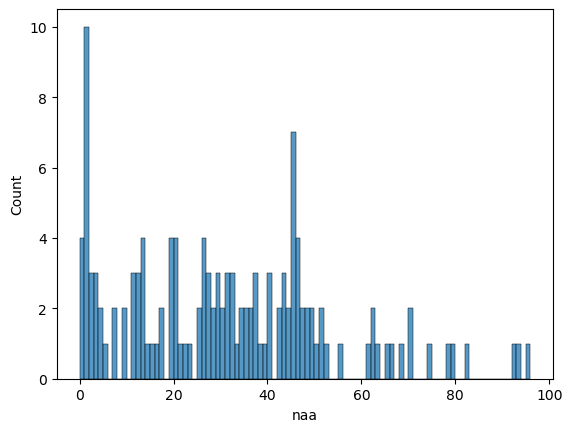

In [19]:
estaciones = pd.read_csv(f'anuario_aforos/{cuenca}/estaf.csv', sep=';', index_col='indroea', encoding='latin1')
estaciones.lugar = estaciones.lugar.str.strip()
estaciones.index.name = 'indroea'

# eliminar columnas vacías
estaciones.dropna(axis=1, how='all', inplace=True)
    
print('nº total de estaciones:\t\t{0}'.format(estaciones.shape[0]))
print('nº de estaciones en servicio:\t{0}'.format(estaciones.loc[estaciones.serv == 1].shape[0]))

sns.histplot(estaciones.naa, binwidth=1);

# exportar todas las estaciones juntas
estaciones.to_csv(f'anuario_aforos/{cuenca}/estaciones.csv', index=True)

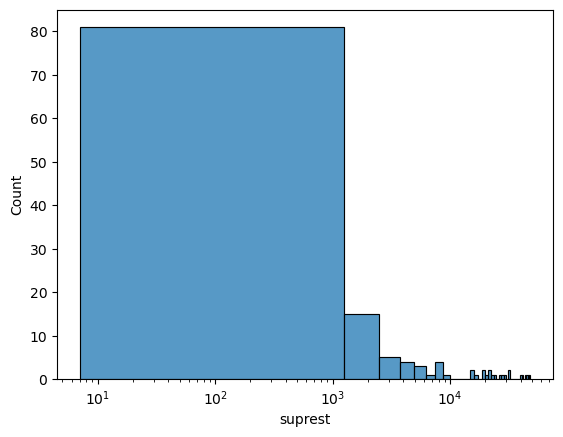

In [20]:
sns.histplot(estaciones.suprest);
plt.xscale('log')

### Embalses

In [21]:

reservoirs = pd.read_csv(f'anuario_aforos/{cuenca}/embalse.csv', sep=';', index_col='ref_ceh', encoding='latin1')

# eliminar columnas vacías
reservoirs.dropna(axis=1, how='all', inplace=True)
    
print('nº total de embalses:\t\t{0}'.format(reservoirs.shape[0]))
print('nº de embalses en servicio:\t{0}'.format(reservoirs.loc[reservoirs.serv == 1].shape[0]))

# exportar todas las estaciones juntas
reservoirs.to_csv(f'anuario_aforos/{cuenca}/embalses.csv', sep=',')

nº total de embalses:		62
nº de embalses en servicio:	51


### Caudal

In [22]:
# cargar series temporales
data = pd.read_csv(f'anuario_aforos/{cuenca}/afliq.csv', sep=';', index_col='indroea')
data.fecha = pd.to_datetime(data.fecha, dayfirst=True)

# recortar a la fecha de estudio
data = data.loc[(data.fecha >= start) & (data.fecha <= end),:]

# reformatear series de caudal y nivel
Q = pd.DataFrame(index=pd.date_range(data.fecha.min(), data.fecha.max(), freq='1d'), columns=data.index.unique(), dtype=float) 
#N = Q.copy()
for stn in Q.columns:
    data_stn = data.loc[stn].set_index('fecha', drop=True)
    Q[stn] = data_stn.caudal
    #N[stn] = data_stn.altura

# convertir nombre de las columnas en texto
Q.columns = [str(col) for col in Q.columns]
#N.columns = Q.columns

# eliminar estaciones sin ningún dato
Q.dropna(axis=1, how='all', inplace=True)
#N.dropna(axis=1, how='all', inplace=True)
    
# exportar series con formato parquet
#Q.to_parquet(f'{folder}/caudal.parquet', index=True)
#N.to_parquet(f'{folder}/nivel.parquet', index=True)

print('{0} estaciones con series de caudal en el {1}'.format(Q.shape[1], cuenca.capitalize()))

# convertir los nombres de las columnas en enteros
Q.columns = [int(stn) for stn in Q.columns]

96 estaciones con series de caudal en el Guadalquivir


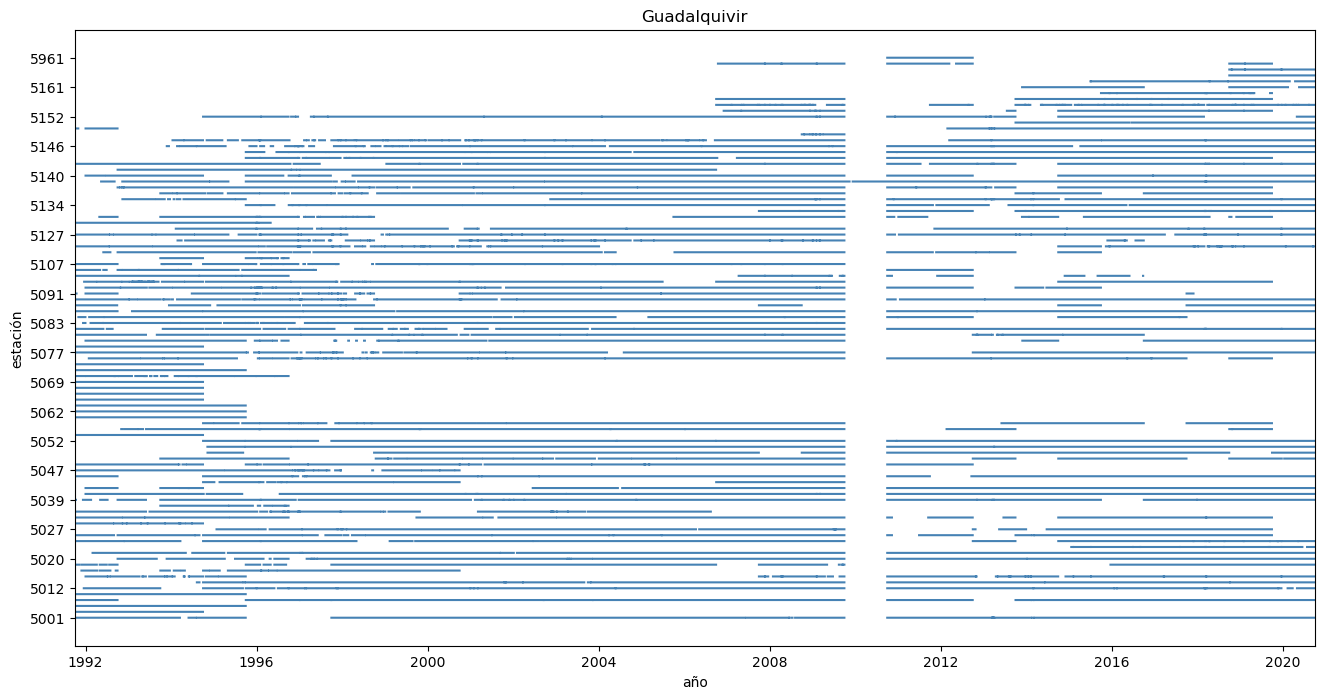

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
for i, stn in enumerate(Q.columns):
    aux = (~Q[stn].isnull()).astype(int).copy()
    aux[aux == 0] = np.nan
    ax.plot(aux * i, color='steelblue')
    
yticks = np.arange(0, Q.shape[1], 5)
ax.set(yticks=yticks, yticklabels=Q.columns[yticks], ylabel='estación',
       xlim=(Q.index.min(), Q.index.max()), xlabel='año',
       title=cuenca.capitalize());
plt.savefig(f'{path_plots}disponibilidad.jpg', dpi=300, bbox_inches='tight');

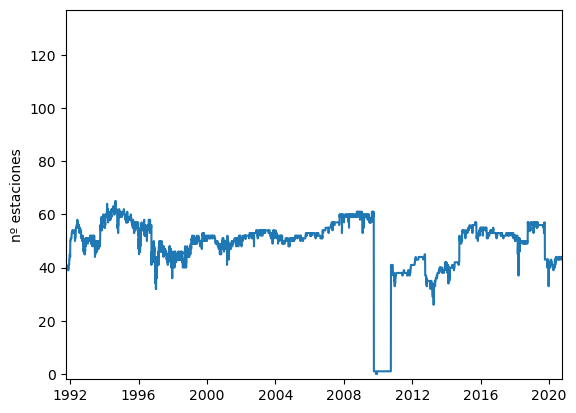

In [24]:
# gráfico de la disponibilidad de estaciones
plt.plot(Q.shape[1] - Q.loc[start:end].isnull().sum(axis=1))
plt.ylim(-2, estaciones.shape[0] + 2)
plt.xlim(start, end)
plt.ylabel('nº estaciones');

In [25]:
#disponibilidad = .85

In [26]:
# seleccionar estaciones con gran cobertura de datos en el periodo de estudio
mask = (np.sum(~Q.isnull(), axis=0) / Q.shape[0]) >= disponibilidad
Q_ = Q.loc[:,mask]
estaciones_ = estaciones.loc[Q_.columns]

print(f'{mask.sum()} estaciones fueron seleccionadas')

7 estaciones fueron seleccionadas


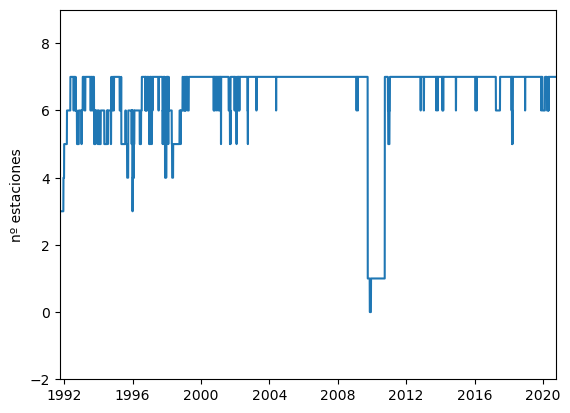

In [27]:
# gráfico de la disponibilidad de estaciones
plt.plot(Q_.shape[1] - Q_.loc[start:end].isnull().sum(axis=1))
plt.ylim(-2, estaciones_.shape[0] + 2)
plt.xlim(start, end)
plt.ylabel('nº estaciones');

In [28]:
def plot_caudal(serie, save=None, **kwargs):
    """
    """
    
    fig, ax = plt.subplots(figsize=kwargs.get('figsize', (16, 4)))
    ax.plot(serie, lw=.8)
    ax.set(xlim=(serie.index.min(), serie.index.max()),
           ylim=(0, None),
           ylabel='Q (m3/s)',
           title=kwargs.get('title', None))
    
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

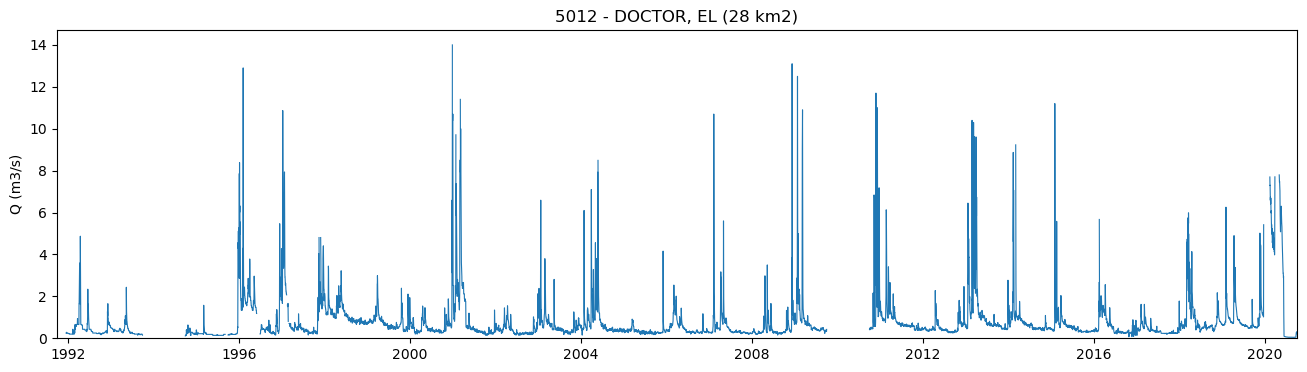

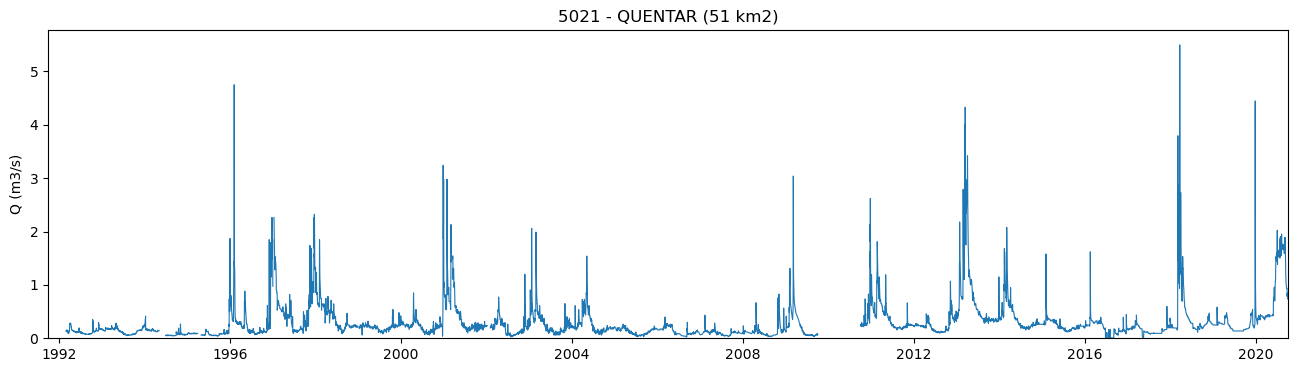

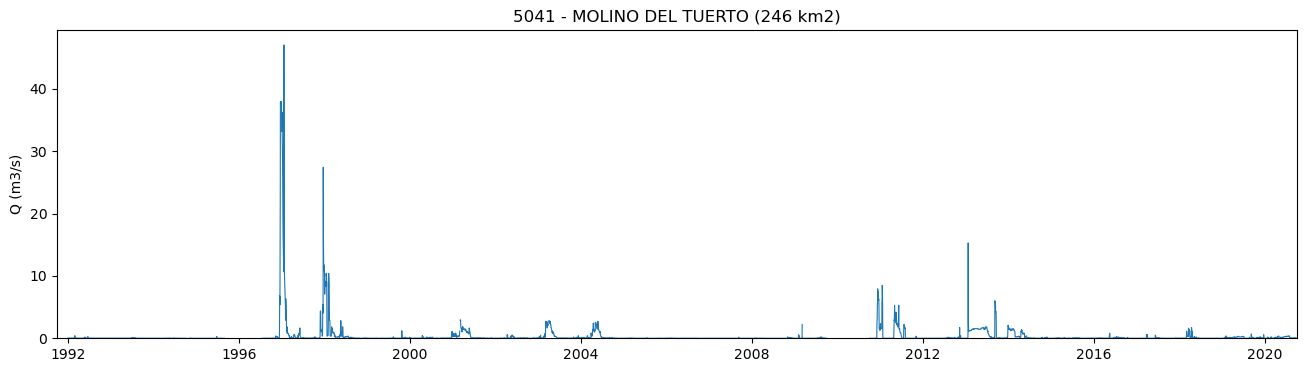

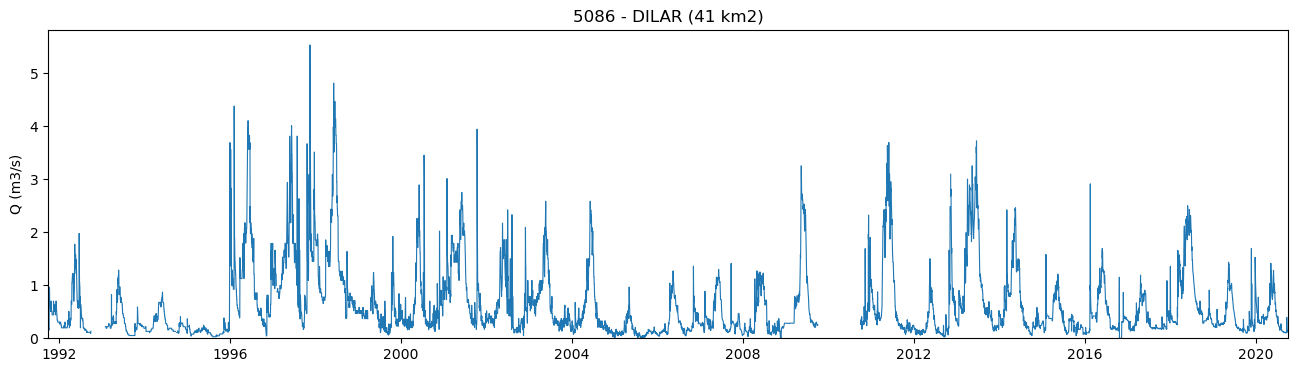

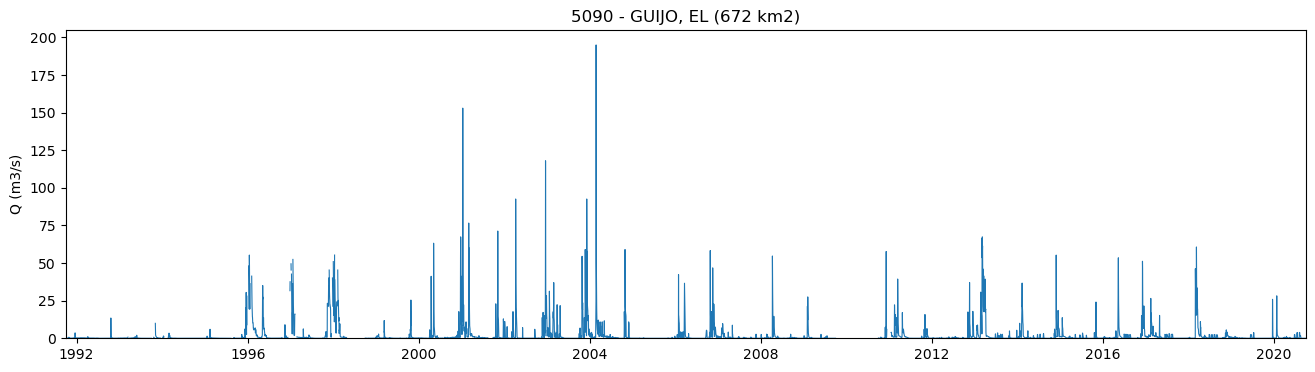

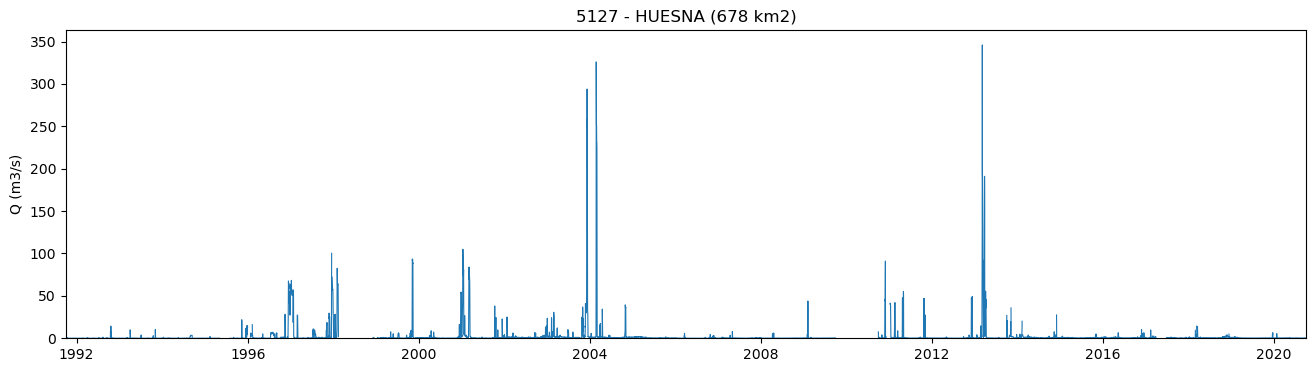

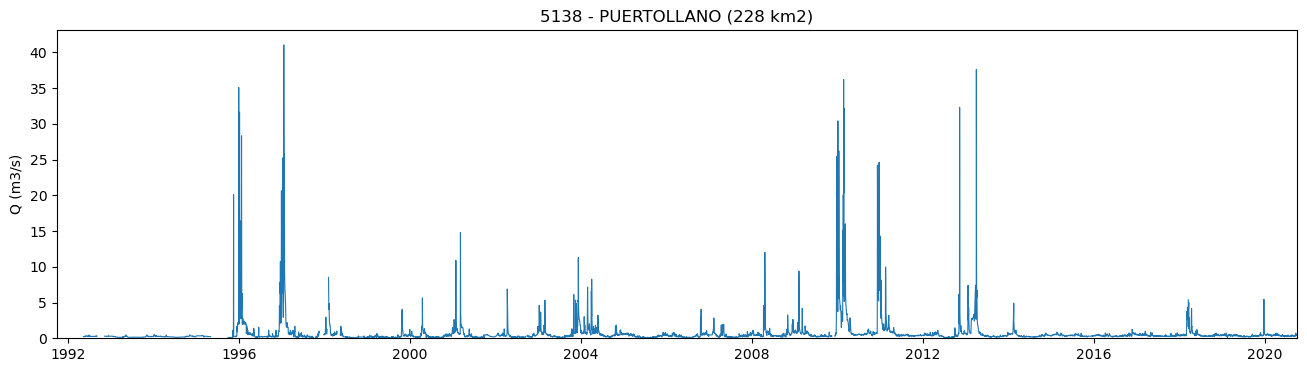

In [29]:
for stn in estaciones_.index:
    plot_caudal(Q[stn],
                title='{0} - {1} ({2} km2)'.format(stn, *estaciones.loc[stn, ['lugar', 'suprest']]),
                save=f'{path_plots}{stn:04}.jpg')

In [31]:
# estaciones a eliminar porque la serie está alterada por embalses
eliminar = {'ebro': [9008, 9010, 9014, 9025, 9026, 9034, 9035, 9036, 9039, 9042,
                     9055, 9056, 9057, 9058, 9083, 9084, 9096, 9097, 9099, 9101,
                     9105, 9106, 9109, 9110, 9113, 9118, 9122, 9124, 9125, 9126,
                     9142, 9145, 9147, 9168, 9176, 9184, 9192, 9216],
            'cantabrico': [],
            'duero': [2002, 2004, 2010, 2011, 2019, 2020, 2022, 2024, 2032, 2040,
                      2041, 2044, 2047, 2049, 2056, 2073, 2075, 2077, 2078,
                      2087, 2102, 2103, 2107, 2108, 2019, 2124, 2129, 2134],
            'tajo': [3003, 3012, 3030, 3041, 3045, 3052, 3060, 3061, 3062, 3067,
                     3070, 3080, 3082, 3144, 3147, 3153, 3158, 3159, 3169, 3186,
                     3213, 3230, 3232, 3238, 3254, 3255, 3259, 3266, 3268, 3940],
            'minho': [],
            'guadalquivir': [5001, 5020, 5039, 5041, 5077, 5090],
            'segura': [7003, 7006, 7013, 7016, 7018, 7030, 7063],
            'jucar': [8005, 8015, 8018, 8025, 8027, 8074, 8093, 8096, 8099, 8107,
                      8112, 8119, 8129, 8139, 8140, 8141, 8147, ],
            'galicia': []}

estaciones_.drop(eliminar[cuenca], axis=0, inplace=True)

print(f'{estaciones_.shape[0]} estaciones fueron seleccionadas')

6 estaciones fueron seleccionadas


In [32]:
# exportar atributos de las estaciones seleccionadas
estaciones_.index.name = 'indroea'
estaciones_.to_csv(f'anuario_aforos/{cuenca}/estaciones_seleccion.csv', index=True)

In [ ]:
estaciones_.shape

In [ ]:
Q.columns

In [ ]:
stn = 7032

plot_caudal(Q[stn],
            title='{0} - {1} ({2} km2)'.format(stn, *estaciones.loc[stn, ['lugar', 'suprest']]),
            save=None)